# Random Forests 4

---

__This Notebook__


- *original goal:*
    - evaluate the results of the last batch of random forest grid searches
    - narrow down search space and conduct final and more robust search

- *results:*
    - unexpectedly low sensitivity; my early attempts achieved 93% sensitivity while the latter, more comprehensive attempts maxed at 89% 

Since "something went wrong" - this notebook turned into troubleshooting and debugging

__The Issue__

- *MinMaxScaler()*:
    - in __Notebook 6: Dimensionality Reduction__ I created a custom `performSVD` function that scaled results to remove negative values from the $V$ matrix so I could run a logistic classifier and "test the waters" with some quick modeling
    - I had no idea that scaling the $V$ matrix would have such great impact on the performance of random forests, with respect to runtime and sensitivity

Below I test the differences in hyperparameters and representations and notice how scaling is the culprit after all

__Results__ 

- the newer grid search yields a model that achieves 96% sensitivity; I can now narrow down and push the envelope a bit


---

## Setup & Load

The are the results of the grid searches in the previous 3 notebooks (__12_RandomForests3.1__, __3.2__, and __3.3__).

In [1]:
import re
import os
import time
import json
import joblib 

import numpy as np
import pandas as pd

from datetime import datetime

dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2021-01-09


In [2]:
# load grid searches
mod_path = os.path.join("data","3_modeling")
gridsearch_names = ['01052021_rf_gridsearches.joblib',
                    '01062021_rf_gridsearches_1.joblib',
                    '01062021_rf_gridsearches_2.joblib',
                    '01062021_rf_gridsearches_3.joblib']

gridsearches = []
for name in gridsearch_names:
    filepath = os.path.join(mod_path, name)
    gridsearches.append(joblib.load(filepath))
        
gridsearches = [item for sublist in gridsearches for item in sublist]        

def extract_df(dic):
    df = pd.concat([
                    pd.DataFrame({'representation':[dic['representation']] \
                                * len(dic['gridsearch_res'].cv_results_["params"])}),
                    pd.DataFrame(dic['gridsearch_res'].cv_results_["params"]),
                    pd.DataFrame(dic['gridsearch_res'].cv_results_["mean_test_acc"], 
                                 columns=["mean_val_acc"]),
                    pd.DataFrame(dic['gridsearch_res'].cv_results_["mean_test_tpr"], 
                                 columns=["mean_val_tpr"]),
                    pd.DataFrame(dic['gridsearch_res'].cv_results_["mean_test_tnr"], 
                                 columns=["mean_val_tnr"])
                    ], axis=1)
    return df

# create list of dfs
df_list = []
for ix, dic in enumerate(gridsearches):
    df_list.append(extract_df(dic))

# flatten and reindex
dfm = pd.concat(df_list)
dfm.index = range(len(dfm))

# sort by top mean validation sensitivity
top_tpr = dfm.sort_values(by=['mean_val_tpr'], ascending=False).iloc[:6,:].copy()
top_tpr

,representation,max_depth,max_features,min_samples_split,n_estimators,mean_val_acc,mean_val_tpr,mean_val_tnr
858,X_bot,20,500,5,100,0.981544,0.894534,0.994876
853,X_bot,20,250,5,200,0.984277,0.894467,0.998027
852,X_bot,20,250,5,100,0.982911,0.891835,0.996846
860,X_bot,20,500,10,100,0.980517,0.889339,0.994479
859,X_bot,20,500,5,200,0.981543,0.889339,0.995663
862,X_bot,20,500,15,100,0.980859,0.886775,0.995269


## Rerunning old grid search

Re-run `scikitlearn_cv`, `collect_cvs`,  `build_random_forests` (a first "gridsearch_wrapper") in ill-attempt to identify why my new gridsearch mean validation true positive rates are worse than my first attempts at building random forests. 

Results below confirm that it is not the old random forest model hypeparameters that were optimal, the issue is with the representations.

In [3]:
import custom.old_gridsearch as og
import scipy.sparse as sp

# load target
raw_path = os.path.join("data","1_raw")
filename = "y_train.csv"
y = pd.read_csv(os.path.join(raw_path, filename))
y = np.array(y.iloc[:,0].ravel())
y[y=='ham'] = 0
y[y=='spam'] = 1
y = y.astype('int')

# load 12 matrices
proc_dir = os.path.join("data","2_processed")
Xnames = ['X_bot_svd_cos.npz', 'X_bot_tfidf_svd_cos.npz']
Xs = []
for ix, X in enumerate(Xnames):
    path_ = os.path.join(proc_dir, Xnames[ix])
    Xs.append(sp.load_npz(path_))

In [32]:
# SAVED CELL
gridsearch = pg.build_random_forests(Xs, 
                                     Xnames,
                                     y,
                                     cv_seed=423, 
                                     rf_seed=514,
                                     mtry_=[50, 100, 250],
                                     trees=500, 
                                     max_leaf_nodes=99, 
                                     cv=10)

In [33]:
# SAVED CELL
gridsearch

,representation,mean_accuracy,mean_sensitivity,mean_specificity,elapsed_seconds,mtry
0,X_bot_svd_cos.npz,0.9746,0.8451,0.9944,707.2,50
1,X_bot_tfidf_svd_cos.npz,0.9787,0.8643,0.9962,553.3,50
2,X_bot_svd_cos.npz,0.9736,0.8490,0.9926,1374.2,100
3,X_bot_tfidf_svd_cos.npz,0.9797,0.8798,0.9950,1063.6,100
4,X_bot_svd_cos.npz,0.9713,0.8432,0.9908,3399.1,250
5,X_bot_tfidf_svd_cos.npz,0.9797,0.8855,0.9941,2772.7,250


---

The old grid searcn run above confirms that it is not the random forest hyperparameters but something else driving the lower mean validation sensitivity.


## Rerunning original representations 

Here I step back to earlier in the project, before the mistake scaling SVD in Notebook 9.

In [6]:
import urlextract
from nltk.stem import WordNetLemmatizer

def load_data(data):
    raw_path = os.path.join("data","1_raw")
    filename = ''.join([data, ".csv"])
    out_dfm = pd.read_csv(os.path.join(raw_path, filename))
    out_arr = np.array(out_dfm.iloc[:,0].ravel())
    return out_arr

X_train = load_data("X_train")
y_train = load_data("y_train")

y = y_train.copy()

# transform y_array into int type
y[y=='ham'] = 0
y[y=='spam'] = 1
y = y.astype('int')

# load contractions map for custom cleanup
with open("contractions_map.json") as f:
    contractions_map = json.load(f)

In [7]:
import custom.clean_preprocess as cp

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

pipe = Pipeline([('counter', cp.DocumentToNgramCounterTransformer(n_grams=3)),
                 ('bot', cp.WordCounterToVectorTransformer(vocabulary_size=2000)),
                 ('tfidf', TfidfTransformer(sublinear_tf=True))
                ])

X_counter = pipe['counter'].fit_transform(X_train)
X_bot = pipe['bot'].fit_transform(X_counter)
X_tfidf = pipe.fit_transform(X_train)

In [8]:
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import svd_flip

def perform_SVD(X, n_components=300):
    
    X_array = X.asfptype()
    U, Sigma, VT = svds(X_array.T, # term-document matrix
                        k=n_components)
    # reverse outputs
    Sigma = Sigma[::-1]
    U, VT = svd_flip(U[:, ::-1], VT[::-1])
    
    # return V 
    V = VT.T
    return V # do not scale for random forests!

X_svd_bot = perform_SVD(X_bot)
X_svd_tfidf = perform_SVD(X_tfidf)

In [9]:
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

X_cossim_svd_bot = cosine_similarity(X_svd_bot)
X_cossim_svd_tfidf = cosine_similarity(X_svd_tfidf)

train_df = pd.DataFrame({'sms':X_train, 'target':y_train})

# get spam indexes
spam_ix = train_df.loc[train_df['target']=='spam'].index

# calculate average spam similarity on SVD
mean_spam_sims_bot, mean_spam_sims_tfidf = [], []

for ix in range(X_cossim_svd_bot.shape[0]):
    mean_spam_sims_bot.append(np.mean(X_cossim_svd_bot[ix, spam_ix]))
    mean_spam_sims_tfidf.append(np.mean(X_cossim_svd_tfidf[ix, spam_ix]))

X_bot_cossim_bot = sp.hstack((csr_matrix(mean_spam_sims_bot).T, X_bot))
X_tfidf_cossim_tfidf = sp.hstack((csr_matrix(mean_spam_sims_tfidf).T, X_tfidf)) 

In [10]:
Xs = [X_bot_cossim_bot, X_tfidf_cossim_tfidf]
Xnames = ['X_bot_cossim_bot', 'X_tfidf_cossim_tfidf']

In [12]:
# much faster when not scaled
gridsearch = og.build_random_forests(Xs, 
                                     Xnames,
                                     y,
                                     cv_seed=423,
                                     rf_seed=514,
                                     mtry_=[50, 100, 250],
                                     trees=500, 
                                     max_leaf_nodes=99, 
                                     cv=10)

In [15]:
gridsearch

,representation,mean_accuracy,mean_sensitivity,mean_specificity,elapsed_seconds,mtry,xticks
0,X_bot_cossim_bot,0.9882,0.9167,0.9991,26.5,50,X_bot_cossim_bot-50
1,X_tfidf_cossim_tfidf,0.9892,0.9303,0.9982,31.3,50,X_tfidf_cossim_tfidf-50
2,X_bot_cossim_bot,0.9885,0.9244,0.9982,33.1,100,X_bot_cossim_bot-100
3,X_tfidf_cossim_tfidf,0.9882,0.9303,0.9970,40.9,100,X_tfidf_cossim_tfidf-100
4,X_bot_cossim_bot,0.9892,0.9340,0.9976,44.5,250,X_bot_cossim_bot-250
5,X_tfidf_cossim_tfidf,0.9885,0.9341,0.9968,58.9,250,X_tfidf_cossim_tfidf-250


This much quicker run reproduces the original results with the 93% mean validation TP rates.

In [16]:
# concatenate representation and n_estimators for plt.xlabel
gridsearch['xticks'] = gridsearch.agg(lambda x: f"{x['representation']}-{x['mtry']}", axis=1)

import matplotlib.pyplot as plt

def plot_topscores(X):
    plt.figure(figsize=(14, 8))
    plt.plot(np.array(X['mean_accuracy']), label="mean validation accuracy")
    plt.plot(np.array(X['mean_sensitivity']), label="mean validation sensitivity")
    plt.plot(np.array(X['mean_specificity']), label="mean validation specificiy")
    plt.title('Evaluating top mean validation sensitivity representations')
    plt.xticks(np.arange(10), tuple(X['xticks']))
    plt.legend(loc="lower right")
    plt.axis([0, 5, 0.9, 1.01])
    plt.xticks(rotation=90)
    plt.show()

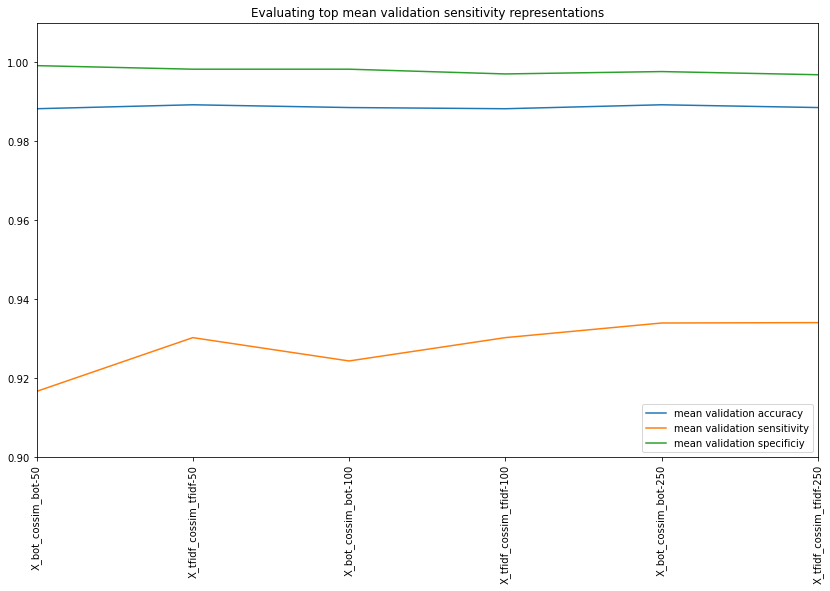

In [17]:
plot_topscores(gridsearch)

## Try new grid search wrapper with non-scaled representations

Finally, I check that the newer grid search performs at least equally well and confirm that the problem was the scaled SVD after all.

In [18]:
def print_eval_metrics(y_val, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    acc = (tp + tn) / (tp + tn + fp + fn)
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    print(f'accuracy: {acc:0.4f}')
    print(f'sensitivity: {tpr:0.4f}')
    print(f'specificity: {tnr:0.4f}')

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

def gridsearch_wrapper(Xs, Xnames, test=False, k=10):
    """
    Performs grid searches and collects them in a list.
    Args:
        Xs: the numeric matrices
        Xnames: their names
        test: faster, shallower searches for testing
        k: the number of CV folds
    """
    
    start_time = time.time()
    model_dir = os.path.join("data", "3_modeling")
    
    # instantiate list of dicts to gather results
    gridsearches = []
    for ix, X_name in enumerate(Xnames):

        X_ = Xs[ix].toarray()
        X_name = X_name.split('.')[0]

        # split into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X_, y, stratify=y)

        # setup testing param grid
        test_param_grid = {
            'min_samples_split': [5, 10, 20], 
            'n_estimators' : [50, 100],
            'max_depth': [10, 20],
            'max_features': [50, 100, 200]
        }

        # setup param grid for final not-too-deep search
        param_grid = {
            'min_samples_split': [5, 10, 15],
            'n_estimators' : [100, 200],
            'max_depth': [5, 10, 20],
            'max_features': [50, 100, 250, 500]
        }

        # setup scorers
        scorers = {
            'acc': make_scorer(accuracy_score),
            'tpr': make_scorer(recall_score, pos_label=1), # sensitivity, recall
            'tnr': make_scorer(recall_score, pos_label=0) # specificity, selectivity
        }

        # instantiate estimator
        clf = RandomForestClassifier(n_jobs=-1, random_state=42)

        # instantiate k-fold gridsearch
        cv_folds = StratifiedKFold(n_splits=k)
    
        if test == True:
            grid_search_clf = GridSearchCV(clf, test_param_grid, # test grid
                                           scoring=scorers, 
                                           refit='tpr', cv=cv_folds, 
                                           return_train_score=True, n_jobs=-1)
        else:
            grid_search_clf = GridSearchCV(clf, param_grid,
                                           scoring=scorers, 
                                           refit='tpr', cv=cv_folds, 
                                           return_train_score=True, n_jobs=-1)           

        # train models
        print(f'\nTraining {ix+1}: {X_name}...')
        start_gs = time.time()
        grid_search_clf.fit(X_train, y_train)
        elapsed_secs = time.time() - start_gs
        print(f'Elapsed: {elapsed_secs:0.0f} s')

        # predict
        y_pred = grid_search_clf.predict(X_val)
        print(f'Best params: {grid_search_clf.best_params_}')

        # confusion matrix on validation set
        print(f'Confusion matrix on validation set:')
        print(pd.DataFrame(confusion_matrix(y_val, y_pred),
                           columns=['pred_neg', 'pred_pos'],
                           index=['neg', 'pos']))
        # eval metrics
        print('Evaluation metrics:')
        print_eval_metrics(y_val, y_pred)

        data = {'representation':X_name,
                'gridsearch_res':grid_search_clf}
        
        # gather results into a list of dicts
        gridsearches.append(data)
        
    mins, secs = divmod(time.time() - start_time, 60)
    print(f'\nTot elapsed: {mins:0.0f} m {secs:0.0f} s')
    return gridsearches

In [20]:
# takes time
start_time = time.time()

gridsearch_cv = gridsearch_wrapper(Xs=Xs, Xnames=Xnames, test=False, k=10)

mins, secs = divmod(time.time() - start_time, 60)
print(f'Elapsed: {mins:0.0f} m {secs:0.0f} s')


Training 1: X_bot_cossim_bot...
Elapsed: 1332 s
Best params: {'max_depth': 20, 'max_features': 500, 'min_samples_split': 5, 'n_estimators': 200}
Confusion matrix on validation set:
     pred_neg  pred_pos
neg       841         5
pos        13       116
Evaluation metrics:
accuracy: 0.9815
sensitivity: 0.8992
specificity: 0.9941

Training 2: X_tfidf_cossim_tfidf...
Elapsed: 1348 s
Best params: {'max_depth': 20, 'max_features': 250, 'min_samples_split': 10, 'n_estimators': 200}
Confusion matrix on validation set:
     pred_neg  pred_pos
neg       844         2
pos         5       124
Evaluation metrics:
accuracy: 0.9928
sensitivity: 0.9612
specificity: 0.9976

Tot elapsed: 44 m 40 s
Elapsed: 44 m 40 s


Guess I forgot I was already printing the total elapsed time already. Oops. 

96% sensitivity is indeed closer to my expectation for the Tfidf plus cosine similarities.

In [23]:
# check save path
save_path = os.path.join(mod_path, "".join(["01092021", "_rf_gridsearches.joblib"]))
save_path

'data\\3_modeling\\01092021_rf_gridsearches`.joblib'

In [24]:
# persist gridsearches
joblib.dump(gridsearch_cv, save_path)

['data\\3_modeling\\01092021_rf_gridsearches`.joblib']

---